<a href="https://colab.research.google.com/github/Luke-Mason/RMIT_Deep_Learning_A1/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [23]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

AUTOTUNE = tf.data.experimental.AUTOTUNE
import tensorflow_datasets as tfds
import pathlib
import shutil
import tempfile
from  IPython import display
import math
from sklearn import preprocessing
import tensorflow.keras as keras
from scipy.ndimage.interpolation import rotate, shift
from tensorflow.keras import layers
from shutil import copy2
!pip install tensorflow-addons
import tensorflow_addons as tfa

import struct
from keras.layers.merge import add, concatenate
import argparse
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, GlobalAveragePooling1D

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from scipy.interpolate import interp1d
import random
import cv2
import matplotlib.patches as patches
from google.colab import drive

# Mount Drive

In [2]:
# Mount the google drive to get the imagery data and get any saved models previously.
drive.mount('/content/drive', force_remount=True)

# Change according to your directory structure
!cp /content/drive/'My Drive'/DL/Distance_dataset.zip .
!unzip -q -o Distance_dataset.zip
!rm Distance_dataset.zip
!ls

# Load the csv data, which contains references to the imagery data.
data = pd.read_csv('./data_updated.csv', delimiter=',')

Mounted at /content/drive
Images/08_OUTSIDE_0969.png  bad CRC d020a927  (should be 4836895b)
data_updated.csv  drive  Images  __MACOSX  README.md  sample_data


# EDA
Data exploration to lead to a well informed approach.

In [ ]:
data.head()

file_path  distance  ...       ymax       ymin
0  Images/07_OUTSIDE_1198.png      14.9  ...  201.65112  170.32014
1  Images/01_OUTSIDE_3420.png       6.7  ...  249.00247  165.39919
2  Images/11_OUTSIDE_5506.png       7.3  ...  231.83516  165.30717
3  Images/06_OUTSIDE_3869.png       7.9  ...  234.96034  174.08122
4  Images/06_OUTSIDE_3952.png       7.5  ...  240.42155  172.18889

[5 rows x 8 columns]

In [ ]:
data.describe()

distance      personID  ...          ymax          ymin
count  12434.000000  12434.000000  ...  12434.000000  12434.000000
mean       9.572044      6.836818  ...    239.087899    168.900679
std        4.520799      3.671217  ...     50.052365     15.919413
min        1.000000      1.000000  ...    139.239030     16.027660
25%        5.800000      4.000000  ...    203.070780    165.088630
50%        9.300000      6.000000  ...    219.942710    169.598395
75%       13.400000     10.000000  ...    256.881728    173.132953
max       19.500000     15.000000  ...    376.000000    313.083800

[8 rows x 6 columns]

## Find corrupt images

Locate any corrupt or missing images in the dataset. In this case 'Images/08_OUTSIDE_0969.png' is not found in the dataset which causes problems. Delete entry from the data pandas frame.

In [11]:
import cv2 as cv
import glob

imagepath = 'Images'
imgs_names = glob.glob(imagepath+'/*.png')
for imgname in imgs_names:
  img = cv.imread(imgname)
  if img is None:
    print(imgname)

Images/08_OUTSIDE_0969.png


Remove Images/08_OUTSIDE_0969.png

In [12]:
data = data[data.file_path != "Images/08_OUTSIDE_0969.png"]

Test removed

In [14]:
data[data.file_path == "Images/08_OUTSIDE_0969.png"]

Empty DataFrame
Columns: [file_path, distance, scene, personID, xmax, xmin, ymax, ymin]
Index: []

## Preview Data

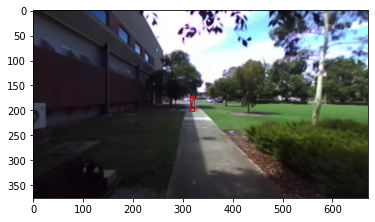

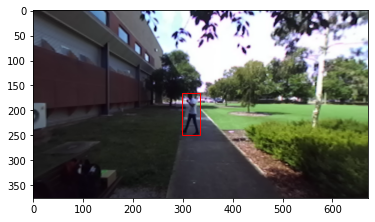

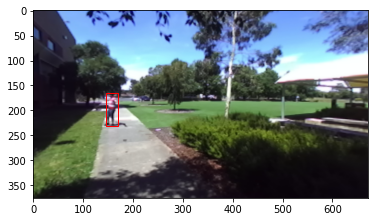

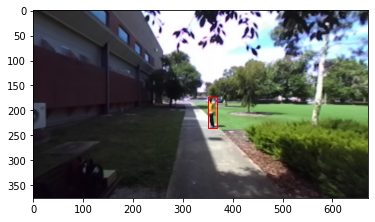

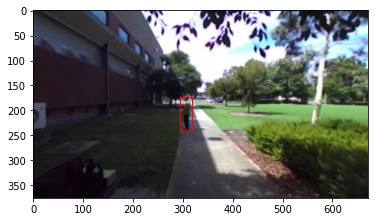

In [5]:
samples = 5

for index, row in data.iterrows():
  if index >= samples:
    continue

  img = np.asarray(Image.open('./' + row["file_path"]))
  xmax = row["xmax"]
  ymax = row["ymax"]
  xmin = row["xmin"]
  ymin = row["ymin"]

  # Create a Rectangle patch
  rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')

  # Create figure and axes
  fig, ax = plt.subplots()

  # Add the patch to the Axes
  ax.add_patch(rect)

  # Display the image
  ax.imshow(img)

## Image Resolutions

In [41]:
largest_height = 0
largest_width = 0
most_bands = 0

img_list = list(data["file_path"])
unique_resolutions = set()

# Check image sizes
for image in img_list:
  img = Image.open('./' + image)
  img_numpy = np.ascontiguousarray(img, dtype=np.float32)
  if largest_height < img_numpy.shape[0]:
    largest_height = img_numpy.shape[0]
  if largest_width < img_numpy.shape[1]:
    largest_width = img_numpy.shape[1]
  if most_bands < img_numpy.shape[2]:
      most_bands = img_numpy.shape[2]
  key = f"({img_numpy.shape[0]}, {img_numpy.shape[1]}, {img_numpy.shape[2]})"
  if key not in unique_resolutions:
    unique_resolutions.add(key)

print("Unique Resolutions: " + str(unique_resolutions))
print("largest dimensions for all images: \nH:{} W:{} C:{}".format(largest_height, largest_width, most_bands))

Unique Resolutions: {'(376, 672, 4)'}
largest dimensions for all images: 
H:376 W:672 C:4


## Data Visualisation

### Functions

In [48]:
def hist_plot(title, columns, colours, nrows, ncols, index_pos, unique_count, xlabel=None, ylabel=None, left=0.125, top=0.9, bottom=0.1, right=0.9, wspace=0.3,
              hspace=0.7, rwidth=1, font_size=16):
    """
    Plots a histogram.
    :param title:       The title of the histogram.
    :param columns:     The data columns to plot on the histogram.
    :param colours:     The colours for each data column on the histogram.
    :param nrows:       The number of rows in the presentation table.
    :param ncols:       The number of columns in the presentation table.
    :param index_pos:   The index of the histogram on the
    :param unique_count The amount of unique results there are for the column.
    :param xlabel       The label for the x axis.
    :param ylabel       The label for the y axis.
    :param left:        How far to move away from left.
    :param top:         How far to move away from top.
    :param bottom:      How far to extend towards bottom.
    :param right:       How far to extend boundary towards right.
    :param wspace:      Height ratio spacing between plots.
    :param hspace:      Width ratio spacing between plots.
    :param rwidth:      The ratio of bar to bucket width. 1 = full cover.
    :param font_size    The size of the font on the axis names.
    :return:
    """
    # Make sub plots space according to parameters.
    plt.subplot(nrows, ncols, index_pos)

    # Give perfect amount of room around each plot to not overlap text.
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

    # Plot histogram for each column feature and assign corresponding colour.
    for index_pos, column in enumerate(columns):
      column.values.sort()
      plt.hist(column.values, alpha=0.3, color=colours[index_pos % len(colours)], density=True, rwidth=rwidth, bins=range(0, unique_count + 1), align='left')
    
    if xlabel is not None:
      plt.xlabel(xlabel, fontsize=font_size, fontstyle='italic') 

    if ylabel is not None:
      plt.ylabel(ylabel, fontsize=font_size, fontstyle='italic') 

    plt.title(title, fontsize=font_size)
    plt.xticks(rotation='vertical')

In [49]:
def bar_plot(title, column_dicts, colours, nrows, ncols, index_pos, unique_count, xlabel=None, ylabel=None, left=0.125, top=0.9, bottom=0.1, right=0.9, wspace=0.3,
              hspace=0.7, font_size=16):
    """
    Plots a bar graph.
    :param title:        The title of the histogram.
    :param column_dicts: The columns dicts to plot on the bars.
    :param colours:      The colours for each data column on the bars.
    :param nrows:        The number of rows in the presentation table.
    :param ncols:        The number of columns in the presentation table.
    :param index_pos:    The index of the histogram on the
    :param unique_count  The amount of unique results there are for the column.
    :param xlabel        The label for the x axis.
    :param ylabel        The label for the y axis.
    :param left:         How far to move away from left.
    :param top:          How far to move away from top.
    :param bottom:       How far to extend towards bottom.
    :param right:        How far to extend boundary towards right.
    :param wspace:       Height ratio spacing between plots.
    :param hspace:       Width ratio spacing between plots.
    :param font_size    The size of the font on the axis names.
    :return:
    """
    # Make sub plots space according to parameters.
    plt.subplot(nrows, ncols, index_pos)

    # Give perfect amount of room around each plot to not overlap text.
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

    # Plot histogram for each column feature and assign corresponding colour.
    for index_pos, dictionary in enumerate(column_dicts):
        plt.bar(dictionary.keys(), dictionary.values(),  alpha=0.3, color=colours[index_pos % len(colours)], align='center')
    
    if xlabel is not None:
      plt.xlabel(xlabel, fontsize=font_size, fontstyle='italic') 

    if ylabel is not None:
      plt.ylabel(ylabel, fontsize=font_size, fontstyle='italic') 

    plt.title(title, fontsize=font_size)
    plt.xticks(rotation='vertical')

In [50]:
def create_graphs(col, col_title, bins, xlabel, index_col, train_set, validation_set, test_set):
  # Graph Action Types
  plt.figure(figsize=(20, 30))
  rwidth=0.80

  # Frequencies
  ylabel = "Frequency Ratio : 1"

  title = "Train Set " + col_title + " Frequencies"
  hist_plot(title, [train_set[col]], [train_colour], 4, 2, 1, bins, rwidth=rwidth, xlabel=xlabel, ylabel=ylabel)

  title = "Validation Set " + col_title + " Frequencies"
  hist_plot(title, [validation_set[col]], [val_colour], 4, 2, 2, bins, rwidth=rwidth, xlabel=xlabel, ylabel=ylabel)

  title = "Test Set " + col_title + " Frequencies"
  hist_plot(title, [test_set[col]], [test_colour], 4, 2, 3, bins, rwidth=rwidth, xlabel=xlabel, ylabel=ylabel)

  title = "All 3 Dataset " + col_title + " Frequencies"
  hist_plot(title, [train_set[col], validation_set[col], test_set[col]], [train_colour, val_colour, test_colour], 4, 2, 4, bins, rwidth=rwidth, xlabel=xlabel, ylabel=ylabel)

  # Counts
  ylabel="Counts $n$"

  train_dict = dict(train_set.groupby(col)[index_col].nunique())
  val_dict = dict(validation_set.groupby(col)[index_col].nunique())
  test_dict = dict(test_set.groupby(col)[index_col].nunique())

  title = "Train Set " + col_title + " Counts"
  bar_plot(title, [train_dict], [train_colour], 4, 2, 5, bins, xlabel=xlabel, ylabel=ylabel)

  title = "Validation Set " + col_title + " Counts"
  bar_plot(title, [val_dict], [val_colour], 4, 2, 6, bins, xlabel=xlabel, ylabel=ylabel)

  title = "Test Set " + col_title + " Counts"
  bar_plot(title, [test_dict], [test_colour], 4, 2, 7, bins, xlabel=xlabel, ylabel=ylabel)

  title = "All 3 Dataset " + col_title + " Counts"
  bar_plot(title, [train_dict, val_dict, test_dict], [train_colour, val_colour, test_colour], 4, 2, 8, bins, xlabel=xlabel, ylabel=ylabel)

### Data

In [52]:
# Define the colours for the graphs.
train_colour = "blue"
val_colour = "red"
test_colour = "green"

# The column that is used as the index/primary key for the dataframe.
index_col = "file_path"

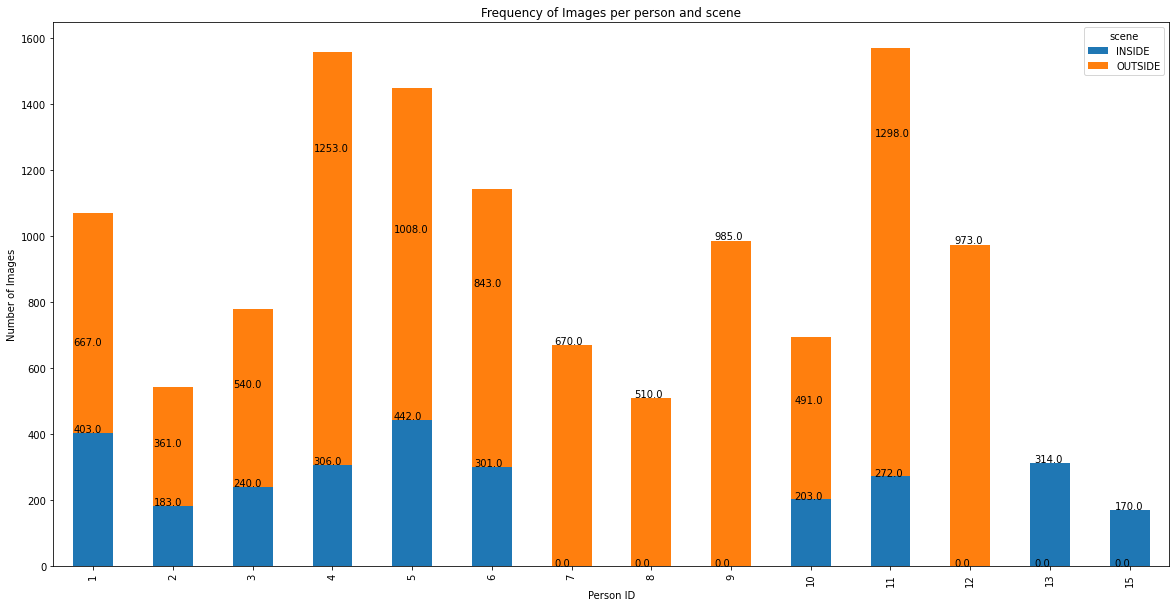

In [16]:
ax = pd.crosstab(data['personID'], data['scene'], margins=False).plot.bar(stacked=True, 
                                                                    figsize=[20,10],
                                                                    title='Frequency of Images per person and scene',
                                                                    xlabel='Person ID',
                                                                    ylabel='Number of Images')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

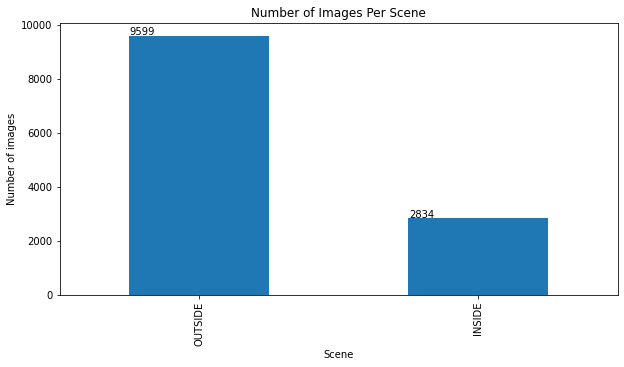

In [17]:
ax = data.scene.value_counts().to_frame().plot(kind='bar',
                                          title='Number of Images Per Scene',
                                          xlabel='Scene', ylabel='Number of images',
                                          legend=False,
                                          figsize=[10,5])

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## Split Data

The way the optimisation works is it performs 1 split per seed, given in the range, and adds the differences per category between, train, validation and test sets and their expected counts, whilst adhering to the split ratios. So if there is a lot of horse data in the train set compared to what was expected based off the train set being 60% the size of the whole set, that will create a large difference number etc. If the difference is much greater than 0 it is bad, where as closer distributed sets are closer to 0, with 0 being a perfect split of all categories among all 3 datasets, evenly.

### Functions

In [35]:
def train_val_test_split_by_column(dataframe, column, seed, train_fraction=0.666, val_fraction=0.5):
    """
    Creates the train, validation and test sets based on a column.
    :param dataframe:      The dataframe that holds the data.
    :param column:         The column to do the splitting on.
    :param seed:           The seed for the randomizer splitter.
    :param train_fraction: The size of the training set.
    :param val_fraction:   The size of the validation set, with the left overs being the test set.
    :return: The train, validation and test sets.
    """

    # Getting the unique column values to split on so that same values are not in different sets.
    splitting_IDs = dataframe[column].unique()

    # Split the train set from the rest.
    train_IDs, test_IDs = train_test_split(splitting_IDs, train_size=train_fraction, shuffle=True, random_state=seed)

    # Split the left over into the validation and test sets.
    val_IDs, test_IDs = train_test_split(test_IDs, train_size=val_fraction, shuffle=True, random_state=seed)

    # Turn into dataframe.
    train_IDs = pd.DataFrame(train_IDs)

    # Create column split with values being train. This lets us distinguish the
    # training data from the other data sets when we merge them all together.
    train_IDs.rename(columns={0: column}, inplace=True)
    train_IDs['split'] = 'train'

    # Turn into dataframe.
    val_IDs = pd.DataFrame(val_IDs)

    # Create column split with values being validation. This lets us distinguish the
    # validation data from the other data sets when we merge them all together.
    val_IDs.rename(columns={0: column}, inplace=True)
    val_IDs['split'] = 'validation'

    # Turn into dataframe.
    test_IDs = pd.DataFrame(test_IDs)

    # Create column split with values being test. This lets us distinguish the
    # test data from the other data sets when we merge them all together.
    test_IDs.rename(columns={0: column}, inplace=True)
    test_IDs['split'] = 'test'

    # Combine the split ids
    splits = pd.concat([train_IDs, val_IDs, test_IDs], ignore_index=True)

    # Add the new columns to original dataframe.
    dataframe = pd.merge(dataframe, splits, on=column)

    # Extract the training set where split equals train.
    train_set = dataframe[dataframe['split'] == 'train']
    train_set = train_set.drop(['split'], axis=1)

    # Extract the validation set where split equals validation.
    validation_set = dataframe[dataframe['split'] == 'validation']
    validation_set = validation_set.drop(['split'], axis=1)

    # Extract the test set where split equals test.
    test_set = dataframe[dataframe['split'] == 'test']
    test_set = test_set.drop(['split'], axis=1)

    return train_set, validation_set, test_set

In [46]:
def get_variance_between_datasets(data, index_col, train_set, validation_set, test_set, cols, train_fraction, validation_fraction):
  """
  Gets the maximum value for each category in the column and calculates how far the other 
  datasets differ from this maximum value in percentage. The differences are 
  added together to create an accumulated difference %. and then each 
  accumulated difference per cell type is added together to create the total 
  accumulated variance.
  
  :param data:           The dataframe containing the data.
  :pram index_col:       The column that the data is unique on.
  :param train_set:      The training data set.
  :param validation_set: The validation data set.
  :param test_set:       The testing data set.
  :param cols:           The columns to calculate and sum the variance on.
  :return: The accumulated difference over the column.
  """

  # Deduce actual test size and validation size.
  remainder_of_the_pie = 1 - train_fraction
  actual_val_fraction = remainder_of_the_pie * validation_fraction
  actual_test_fraction = remainder_of_the_pie - actual_val_fraction

  # Initialise varaince to 0.
  total_variance = 0

  # For each target column, get the variance of the data between the datasets.
  for y_col in cols:

    train_values = dict(train_set.groupby(y_col)[index_col].nunique())
    validation_values = dict(validation_set.groupby(y_col)[index_col].nunique())
    test_values = dict(test_set.groupby(y_col)[index_col].nunique())


    # Loop through the different categories in main data.
    for key in data.groupby(cols)[index_col].nunique().keys().values:

      # Get the frequency count for each cell type, 0 if class doesn't exist.
      actual_train_count = train_values[key] if key in train_values else 0
      actual_val_count = validation_values[key] if key in validation_values else 0
      actual_test_count = test_values[key] if key in test_values else 0

      # Get total count of data.
      total_count = actual_train_count + actual_val_count + actual_test_count

      # Get the expected count for each dataset.
      train_expected_count = total_count * train_fraction
      val_expected_count = total_count * actual_val_fraction
      test_expected_count = total_count * actual_test_fraction

      # Get the difference between the expected count and the actual count.
      train_diff = abs(train_expected_count - actual_train_count)
      val_diff = abs(val_expected_count - actual_val_count)
      test_diff = abs(test_expected_count - actual_test_count)

      # Get the total difference in how much the data sets differ from the expected values.
      # Best case scenario is that they are all equal and difference = 0.
      total_variance += train_diff + val_diff + test_diff
  
  return total_variance


In [37]:
def optimise_split(data_set, index_col, target_columns, iterations, train_fraction=0.666, val_fraction=0.5):
  """
    Optimises the split by splitting many times to find the split that contains the least variance in data across all splits on an optimised column.
    :param data_set:       The data set to split.
    :param index_col:      The column to split on, the unique values column or index.
    :param target_columns: The target columns to calculate the variance on.
    :param iterations:     How many seeds to check from 0.
    :return: The optimal seed and the variance for the seed.
    """
  seed = 0
  smallest_variance = 9999
  
  for i in range(1, iterations):
  
    # Split the data based on patient ID.
    train_set, val_set, test_set = train_val_test_split_by_column(data_set, index_col, i, train_fraction, val_fraction)

    # Calculate the variance between the three datasets.
    variance = get_variance_between_datasets(data_set, index_col, train_set, val_set, test_set, target_columns, train_fraction, val_fraction)

    if variance < smallest_variance:
      smallest_variance = variance
      seed = i

  return seed, smallest_variance

### Split

In [47]:
# Split the data
train_fraction = 0.8
val_fraction = 0.5

seed, smallest_variance = optimise_split(data, index_col, ['scene', 'personID'], 200, train_fraction, val_fraction)

print("Best seed: " + str(seed))
print("Accumulated Variance: " + str(smallest_variance))

Best seed: 1
Accumulated Variance: 0.0


In [57]:
# Split on the ultimate seed split with the least variance over the patient data.
train_set, validation_set, test_set = train_val_test_split_by_column(data, index_col, seed, train_fraction, val_fraction)

In [59]:
train_set.head()

file_path  distance  ...       ymax       ymin
0  Images/07_OUTSIDE_1198.png      14.9  ...  201.65112  170.32014
1  Images/01_OUTSIDE_3420.png       6.7  ...  249.00247  165.39919
2  Images/11_OUTSIDE_5506.png       7.3  ...  231.83516  165.30717
3  Images/06_OUTSIDE_3869.png       7.9  ...  234.96034  174.08122
5  Images/09_OUTSIDE_1805.png      14.7  ...  201.14867  169.35344

[5 rows x 8 columns]

### Visualise Splits

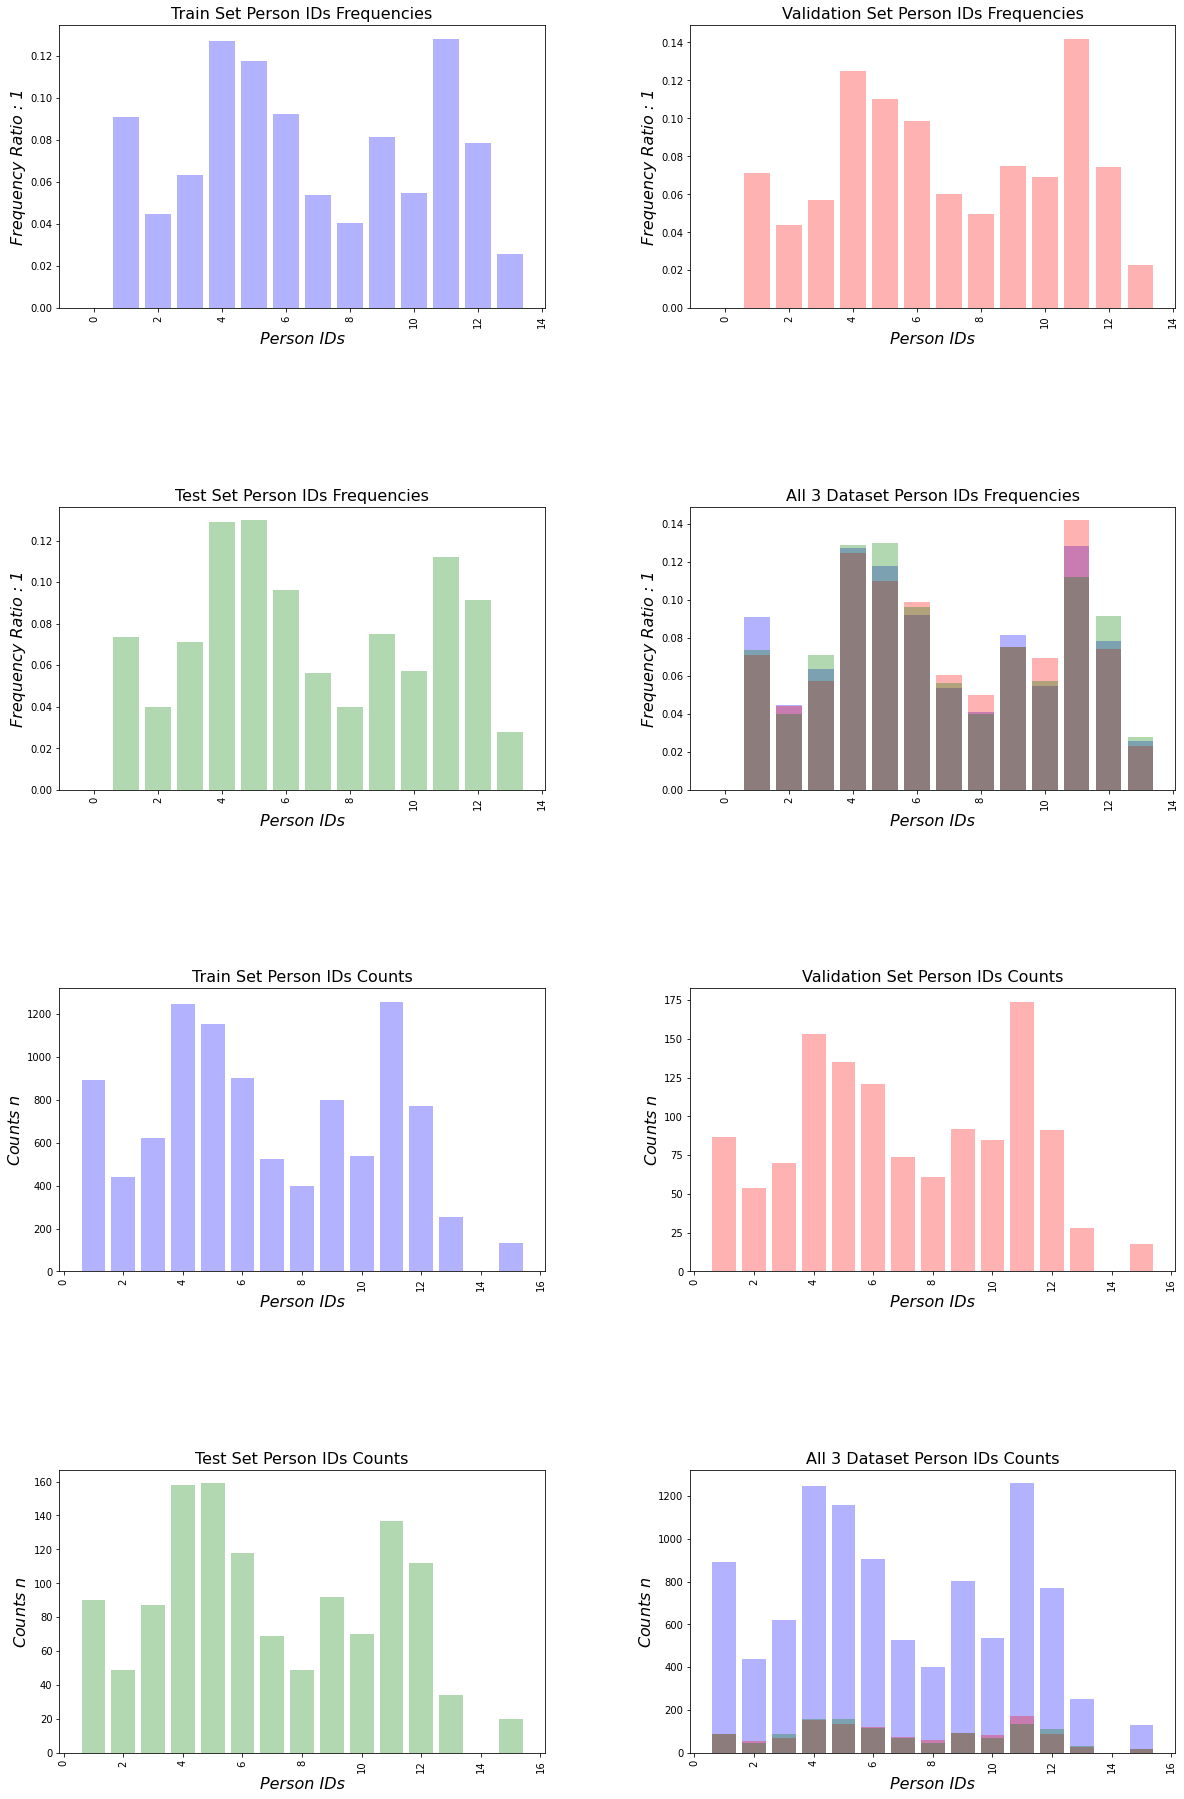

In [55]:
bins = data["personID"].nunique()
create_graphs("personID", "Person IDs", bins, "Person IDs", index_col, train_set, validation_set, test_set)

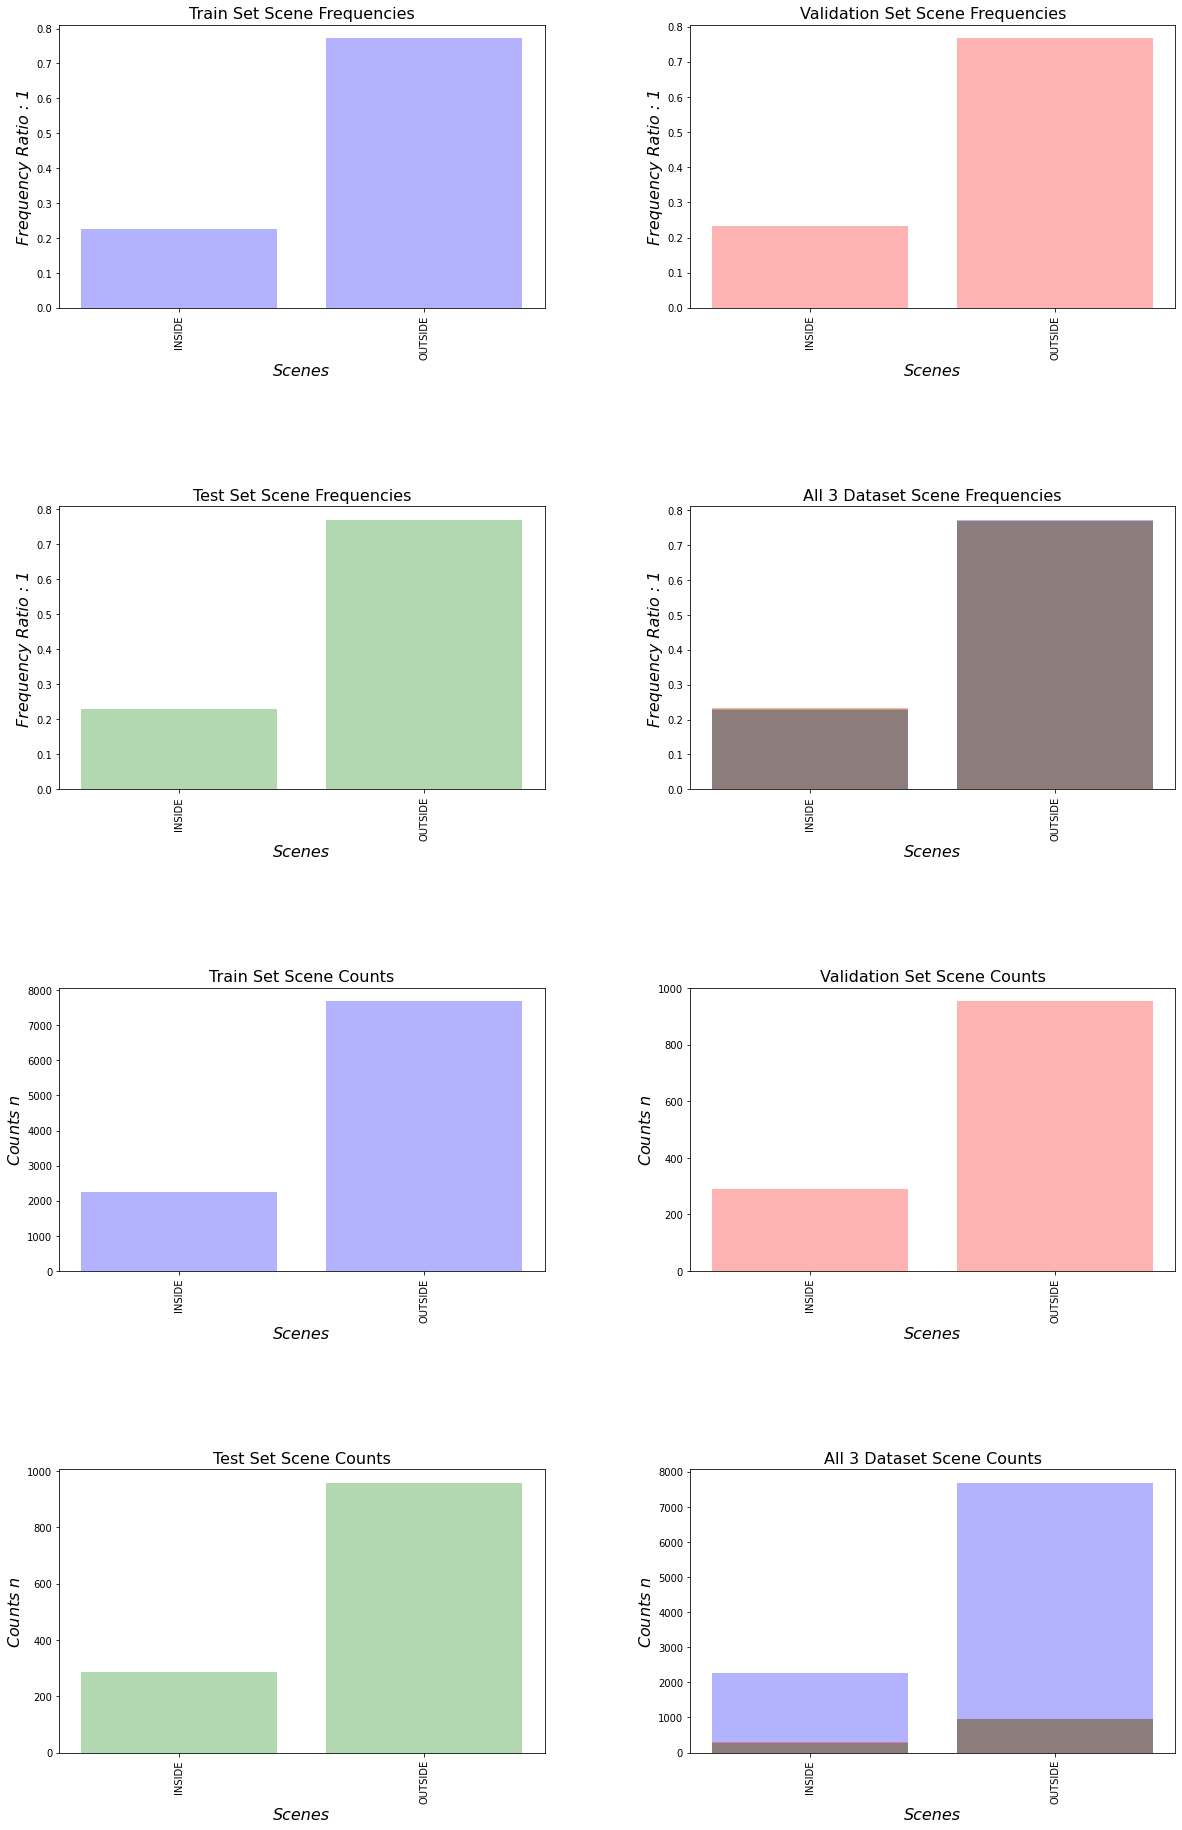

In [56]:
bins = data["scene"].nunique()
create_graphs("scene", "Scene", bins, "Scenes", index_col, train_set, validation_set, test_set)

## Performance Metric
Mean Average Precision
mAP@0.5 and mAP@0.25


👨🏻‍🎓 **Conclusions**
> - 



[Ref](https://www.datacamp.com/community/tutorials/object-detection-guide)



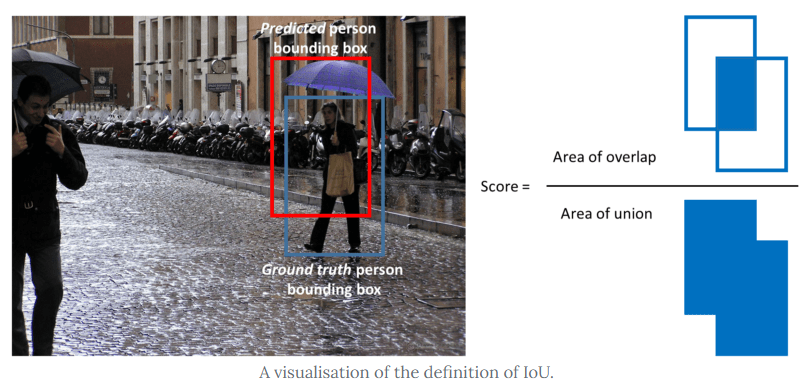

## Base Model

There was needed a base model to help initialise the weights of the model to be in a state that is already familiart and suited to this calssification task. Two base models were chosen based on the complexity of the models and pramater output size. 


Both these base models will be frozen and not fine tuned do to the size of them after the head has been tuned. If there was more resources dedicated towards also finetuning the base model for the task, that would be good for further future investigation.

👨🏻‍🎓 **Conclusions**
> - Test both base models:
    - YOLOv3

## Optimizer

Adam will be the opimizers to test going forward.
Adam will be used purely for it's speed increase to a models training.
Though SGD is good as an optimizer as well, it is very slow compared to Adam and requires a learning rate that is not small. The learnig rate that will be chosen for this project will be quite smaller, being around 0.0005.


[1]: Wilson, Ashia C. et al. “The Marginal Value of Adaptive Gradient Methods in Machine Learning.” ArXiv abs/1705.08292 (2017): n. pag

# Literature Review

- SSD architecture
- R-CNN
- Fast-R-CNN
- Faster-R-CNN
- YOLOv3



## SSD Architecture
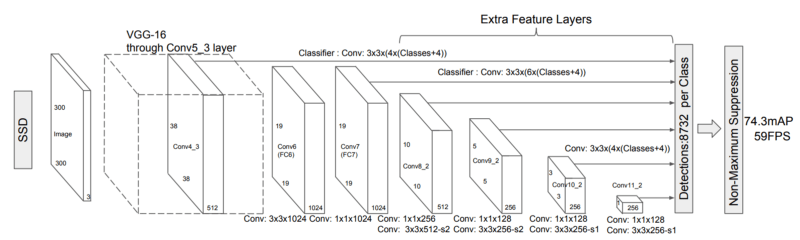

## YOLO v3 Architecture
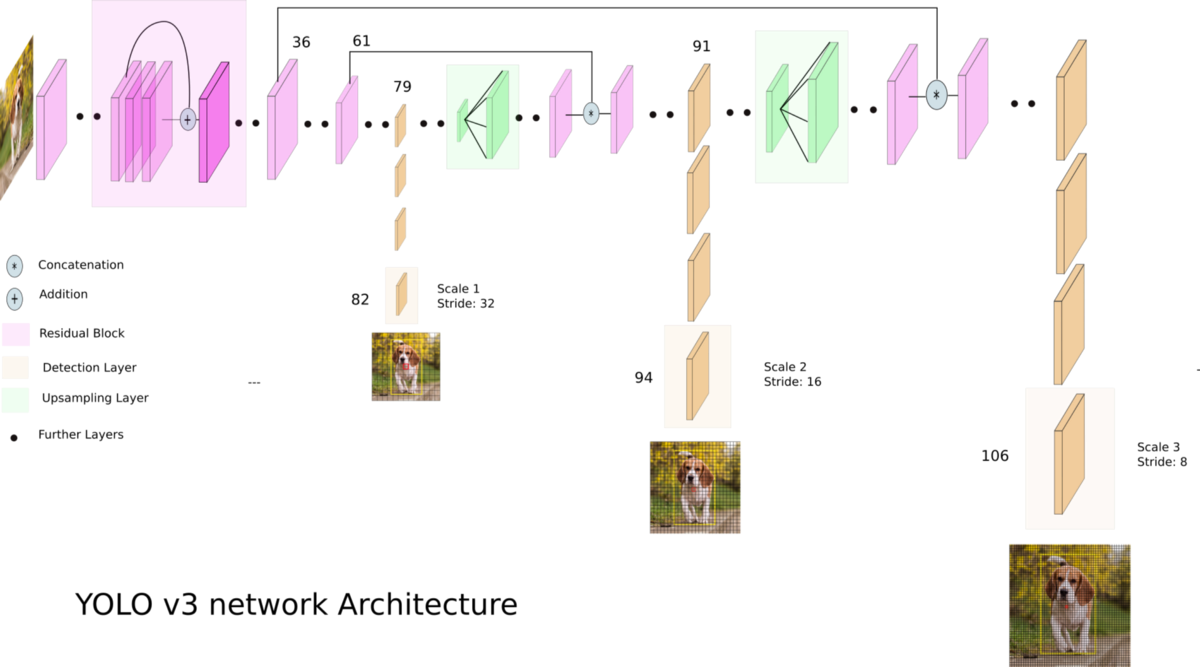

# Setup


## Model Saving Functions

In [31]:
def setup_model_store(model_name):
    """
    Sets up the paths and directories necessary to save the model and training history of that model.
    :param model_name: The name of the model.
    :return: The full path of the model directory and the full path location for the history.
    """
    # Train MLP.
    print("~~~~~~~~~~ " + model_name + " ~~~~~~~~~~")

    # Root google dir.
    root_dir = "/content/drive/My Drive/Deep_Learning/"

    # Get root dir for this model.
    model_dir = root_dir + "models/" + model_name

    # Make path for models.
    model_path = model_dir + "/checkpoint.tf"

    # Make path for history logs.
    history_path = model_dir + "/history.csv"

    # Make a directory if it doesn't exist. Any error output do not show.
    !mkdir / content / drive / 'My Drive' / CML-Assignment-2 / {model_dir} 2 > / dev / null

    return model_path, history_path

Create Custom Callback to save epock checkpoint history to history file

In [32]:
# Create call back to provide an update message of the model after epoch end.
class UpdateHistoryCallback(keras.callbacks.Callback):
    def __init__(self, history_path, epochs_completed, total_epochs):
      self.history_path = history_path
      self.epochs_completed = epochs_completed
      self.total_epochs = total_epochs

    def on_epoch_end(self, epoch, logs=None):

      # Check the history csv exists.
      exists = os.path.isfile(self.history_path)
      with open(self.history_path, 'a') as file:
        
        # Append header line to csv if file is newly created.
        if not exists:
          file.write(",".join(logs.keys()) + "\n")
        
        # Write the epoch's metrics to history file.
        file.write(",".join(map(str, logs.values())) + "\n")
        print("Epoch " + str(self.epochs_completed + epoch + 1) + "/" + str(self.total_epochs) + " Complete")

Create the auto save and auto load function.
Can auto continue training from last saved epoch.

In [33]:
def run_model(model, parameters, model_name, train_generator, val_generator, extend_model_name=None):
    """
    Runs a model but checks if it is already saved and loads it in if it exists.
    Otherwise it fits the model and saves the model and it's history.
    :param model:            The model to fit.
    :param parameters:       The hyper parameters.
    :param model_name:       The name of the model.
    :param train_generator:  The train generator.
    :param val_generator:    The validation generator.
    :param extend_model_name The name of the model to extend from with further training.
    :return: The history created/found and the model created/found.
    """
    
    previous_model_name = model_name
    

    # Setup the directories and paths for saving and loading the model and history.
    model_path, history_path, = setup_model_store(model_name)
    
    continue_training = False
    epochs = parameters["epochs"]
    trained_epochs = 0
    try:
      # Load a model that exists.
      model = tf.keras.models.load_model(model_path)
      print("Accessed: " + model_path)

      # Read in the history chart from fitting the model previously.
      history = pd.read_csv(history_path, delimiter=',')
      print("Accessed: " + history_path)

      # Check if the model was stopped early in training
      trained_epochs = len(history['loss'])

      # Check if the model can prematurely stopped training.
      if trained_epochs < epochs:
        
        # Continue where the model left off from.
        continue_training = True

        # Set the remaining amount of epochs to train on the model.
        epochs = epochs - trained_epochs
        raise  Exception()
    except:

      # If create new model
      if not continue_training:

        # If create new model from existing model
        if extend_model_name is not None:
          mp, h = setup_model_store(extend_model_name)

          # Copy existing history from model to new one.
          dir = os.path.dirname(history_path)
          os.mkdir(dir)
          copy2(h, history_path)


          # Load other model to train from
          model = tf.keras.models.load_model(mp)
        else:

          # If create new model from scratch
          print("Creating new model..")
          # Compile the model with the hyper parameters chosen.
          model.compile(optimizer=parameters["optimizer"],
                        loss=parameters["loss"],
                        metrics=parameters["metrics"])
      else:

        print("Continuing training model ...")
        print("Epochs done: " + str(trained_epochs))  
        print("Epochs left: " + str(epochs))
      
      checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
      history_cb = UpdateHistoryCallback(history_path, trained_epochs, parameters["epochs"])

      # Fit the model with the generators, and epoch amount.
      model.fit(train_generator,
                validation_data=val_generator, 
                epochs=epochs, 
                verbose=0,  
                callbacks = [checkpoint_cb, history_cb])
    
    history = pd.read_csv(history_path, delimiter=',')
    return history, model

## Data Generators Creator

In [19]:
def get_imagery_data_sets(train_set, validation_set, test_set, directory, x_col, y_col, batch_size, target_size, aug_params=None):
    """
    Gets the imagery data from the reference id's in each data set.
    :param train_set: The dataframe containing the set of ids in the training set.
    :param validation_set: The dataframe containing the set of validation ids.
    :param test_set: The dataframe containing the test ids.
    :param directory: The directory that the images are located.
    :param y_col: The target column name to make the taget column into a string type.
    :param batch_size: The batch size to which the data generator batches the imagery data.
    :param aug_params: the parameters for the data generator for the training set to help augment the data.
    :return: Returns the 3 data generators (train, validation, test) that have the images data.
    """

    # Transform the pixel values between 0 and 1, by dividing their values by 1/255
    train_datagen = ImageDataGenerator(rescale=1. / 255, data_format='channels_last') if aug_params == None else ImageDataGenerator(rescale=1. / 255, data_format='channels_last', **aug_params)
    val_datagen = ImageDataGenerator(rescale=1. / 255, data_format='channels_last')
    test_datagen = ImageDataGenerator(rescale=1. / 255, data_format='channels_last')

    # The parameters that all data set generators have in common.
    generator_parameters = dict(
        directory=directory,
        x_col=x_col,
        y_col=y_col,
        # TODO Get file_path
        target_size=target_size,
        color_mode="rgba",
        class_mode='multi_output',
        shuffle=False)

    # Train set generator to evaluate produce dataframe with train images.
    train_imagery_set = train_datagen.flow_from_dataframe(
        dataframe=train_set,
        batch_size=batch_size,
        **generator_parameters)

    # Validation set generator to evaluate produce dataframe with validation images.
    val_imagery_set = val_datagen.flow_from_dataframe(
        dataframe=validation_set,
        batch_size=batch_size,
        **generator_parameters)

    # Test set generator to evaluate produce dataframe with test images.
    test_imagery_set = test_datagen.flow_from_dataframe(
        dataframe=test_set,
        batch_size=1,
        **generator_parameters)

    return train_imagery_set, val_imagery_set, test_imagery_set

Found 9946 validated image filenames.
Found 1243 validated image filenames.
Found 1244 validated image filenames.


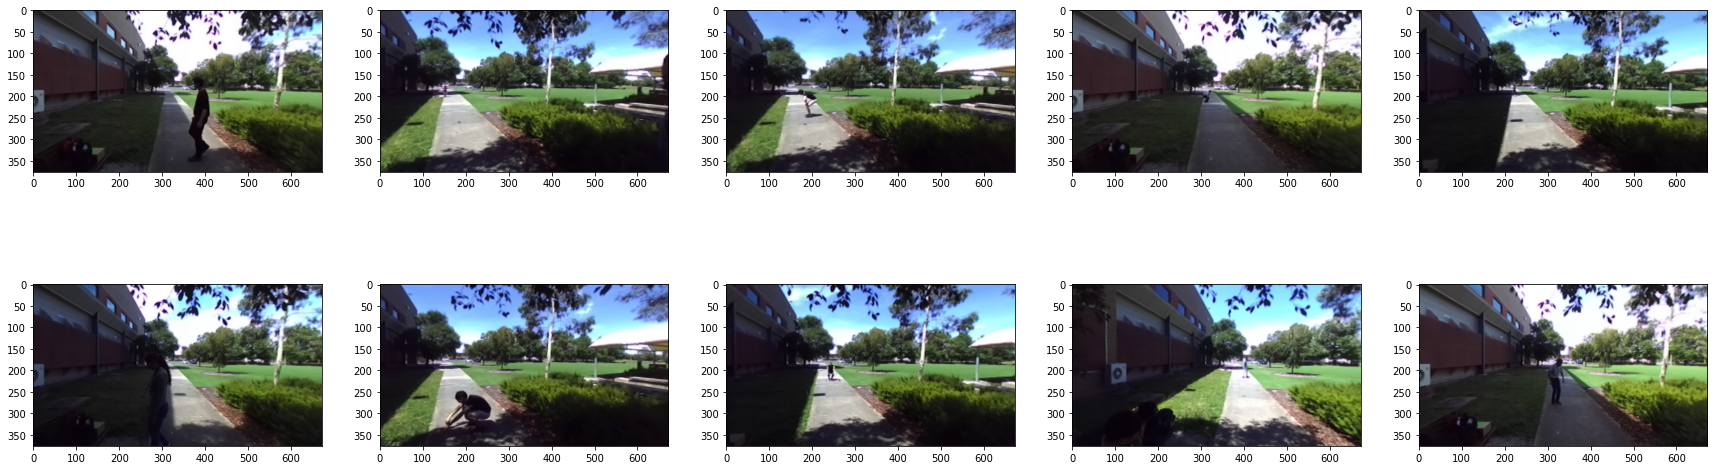

In [20]:
train_gen, val_gen, test_gen = get_imagery_data_sets(train_set, val_set, test_set, "./", 'file_path', ["xmin", "ymin", "xmax", "ymax"], 5, (376, 672))

plt.figure(figsize=[30, 100])

count = 0
for i in range(0, 2):
  x,y = train_gen.__getitem__(i)
  img_in_batch = x.shape[0]
  for index in range(0, img_in_batch):
    img = x[index]
    plt.subplot(20, 5, count + 1)

    count += 1

    plt.imshow(img)


# Train Person Detection

In [28]:
INIT_LR = 0.001
NUM_EPOCHS = 25
BATCH_SIZE = 32
INPUT_SIZE = (376, 672)
METRICS_CI = [
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc',curve='ROC',),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

train_gen, val_gen, test_gen = get_imagery_data_sets(train_set, val_set, test_set, "./", 'file_path', ["xmin", "ymin", "xmax", "ymax"], BATCH_SIZE, INPUT_SIZE)

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  INIT_LR,
  decay_steps=train_gen.__len__() * 1000,
  decay_rate=10,
  staircase=False)

# Hyperparameters.
parameters = {
    # Compile parameters.
    "optimizer": tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    "loss": tf.keras.losses.MeanSquaredError(),
    "metrics": METRICS_CI,

    # Generator Parameters.
    "batch_size": BATCH_SIZE,

    # Fit perameters.
    "epochs": NUM_EPOCHS
}

reg_lambda = 0.001

Found 9946 validated image filenames.
Found 1243 validated image filenames.
Found 1244 validated image filenames.


In [29]:
# Model
IMG_SHAPE = (None,None, 3)
inputs = keras.Input(shape=IMG_SHAPE)
base_model = tf.keras.applications.InceptionV3(input_tensor=inputs, 
                                               include_top=False, 
                                               weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False

# flatten the max-pooling output of InceptionV3
x = base_model.output
x = tf.keras.layers.BatchNormalization(momentum=.4)(x)

# x = GlobalAveragePooling1D()(x)


# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), kernel_initializer="he_normal")(x)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)

# 4 Neurons for the 4 bounding box coordinates.
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=base_model.input, outputs=bboxHead)
model.summary()
model_name = "test"

# TODO  https://www.youtube.com/watch?v=b5_B9oNqaqE

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_471 (BatchN (None, None, None, 3 96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, None, None, 3 0           batch_normalization_471[0][0]    
______________________________________________________________________________________________

In [62]:
y_cols = ["xmin", "xmax", "ymin", "ymax"]
train_generator, val_generator, test_generator = get_imagery_data_sets(train_set, validation_set, test_set, "", "file_path", y_cols, BATCH_SIZE, INPUT_SIZE)

history, model = run_model(model, parameters, model_name, train_generator, val_generator)

Found 9946 validated image filenames.
Found 1243 validated image filenames.
Found 1244 validated image filenames.
~~~~~~~~~~ test ~~~~~~~~~~
/bin/bash: /: Is a directory
Accessed: /content/drive/My Drive/Deep_Learning/models/test/checkpoint.tf
Accessed: /content/drive/My Drive/Deep_Learning/models/test/history.csv
Continuing training model ...
Epochs done: 3
Epochs left: 22


ValueError: ignored

## Helper functions for running and evaluation YOLO v3 model output.

In [ ]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def preprocess_input(image, net_h, net_w):
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image

def decode_netout(netout, anchors, obj_thresh, nms_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]
            
            if(objectness.all() <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
        
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0
                    
def draw_boxes(image, boxes, labels, obj_thresh):
    for box in boxes:
        label_str = ''
        label = -1
        
        for i in range(len(labels)):
            if box.classes[i] > obj_thresh:
                label_str += labels[i]
                label = i
                print(labels[i] + ': ' + str(box.classes[i]*100) + '%')
                
        if label >= 0:
            cv2.rectangle(image, (box.xmin,box.ymin), (box.xmax,box.ymax), (0,255,0), 3)
            cv2.putText(image, 
                        label_str + ' ' + str(box.get_score()), 
                        (box.xmin, box.ymin - 13), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        1e-3 * image.shape[0], 
                        (0,255,0), 2)
        
    return image 

## Create YOLO V3 Model

In [ ]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

[YOLOv3 Architecture](https://miro.medium.com/max/1200/1*d4Eg17IVJ0L41e7CTWLLSg.png)

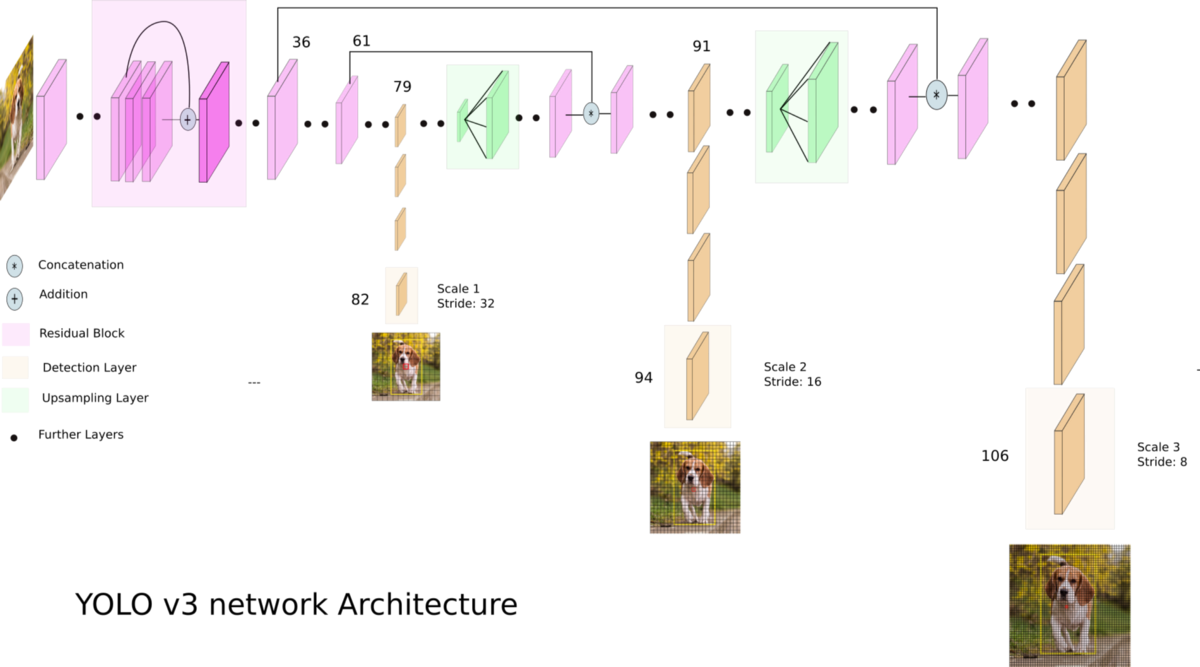

# Raw Person Detection Performance

In [ ]:
# Make the yolov3 model to predict 80 classes on COCO.
yolov3 = make_yolov3_model()

In [ ]:
weights_path = "/content/drive/MyDrive/DL/yolov3.weights"

# Load the weights trained on COCO into the model.
weight_reader = WeightReader(weights_path)
weight_reader.load_weights(yolov3)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [ ]:
train_gen, val_gen, test_gen = get_imagery_data_sets(train_set, val_set, test_set, "./", 'file_path', ["xmin", "ymin", "xmax", "ymax"], 1, INPUT_SIZE)

x,y = train_gen.__getitem__(0)
x.shape

Found 9947 validated image filenames.
Found 1243 validated image filenames.
Found 1244 validated image filenames.


(1, 376, 672, 4)

In [ ]:
x.shape[1]

376

In [ ]:

# set some parameters
net_h = 500
net_w = 500

obj_thresh, nms_thresh = 0.5, 0.45
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", 
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", 
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", 
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", 
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", 
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", 
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", 
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", 
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", 
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

# preprocess the image.
image_path = "./Images/01_INSIDE_00044.png"
# image = cv2.imread(image_path)
# image_h, image_w, _ = image.shape
# new_image = preprocess_input(image, net_h, net_w)

# train_gen.__getitem__(0)

# print(new_image.shape)

def loadImage(image_path):
  img = tf.keras.preprocessing.image.load_img(image_path)
  img = tf.keras.preprocessing.image.img_to_array(img, dtype = 'float32')
  
  return img/255

img = loadImage(image_path)

pixels = np.expand_dims(img, axis=0)
print(pixels.shape)

# run the prediction
yolos = yolov3.predict(pixels)
boxes = []

for i in range(len(yolos)):
    # decode the output of the network.
    boxes += decode_netout(yolos[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)

# correct the sizes of the bounding boxes
correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

# suppress non-maximal boxes
do_nms(boxes, nms_thresh)     

# draw bounding boxes on the image using labels
draw_boxes(image, boxes, labels, obj_thresh) 

# write the image with bounding boxes to file
cv2.imwrite(image_path[:-4] + '_detected' + image_path[-4:], (image).astype('uint8')) 

(1, 376, 672, 3)


ValueError: ignored

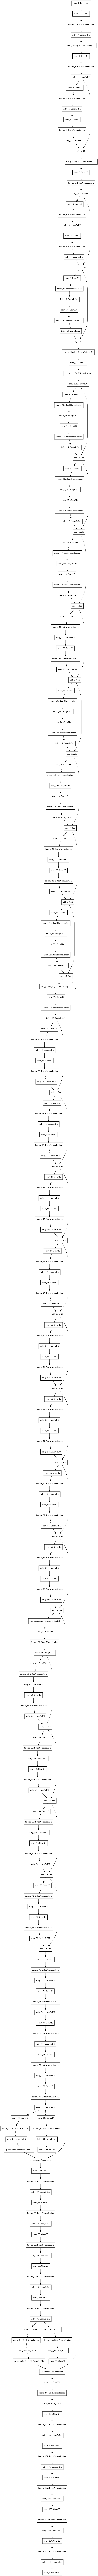

In [ ]:
keras.utils.plot_model(model, "yolov3.png")